<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials/blob/main/12_cnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images
import torchvision
import torchvision.transforms.v2 as T
import torch.nn as nn
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [3]:
torch.manual_seed(42)

# Сверточные слои

In [4]:
sample_image = np.stack(load_sample_images()["images"])
sample_image = torch.tensor(sample_image, dtype=torch.float32) / 255

In [5]:
sample_image.shape

torch.Size([2, 427, 640, 3])

In [6]:
sample_image_permuted = sample_image.permute(0,3,1,2)
sample_image_permuted.shape

torch.Size([2, 3, 427, 640])

In [7]:
cropped_images = T.CenterCrop((70, 120))(sample_image_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

In [8]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

In [9]:
fmaps.shape

torch.Size([2, 32, 64, 114])

In [10]:
conv_layer.weight.shape, conv_layer.bias.shape

(torch.Size([32, 3, 7, 7]), torch.Size([32]))

In [11]:
max_pool = nn.MaxPool2d(kernel_size=2)

In [12]:
class DepthPool(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding


    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)
        Z = Z.permute(0,2,1)
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        Z = Z.permute(0, 2, 1)
        return Z.view(batch, -1, height, width)

In [13]:
global_avg_pool = nn.AvgPool2d(kernel_size=(70, 120))
output = global_avg_pool(cropped_images)

In [14]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_images)

In [15]:
output = cropped_images.mean(dim=(2,3), keepdim=True)

# Архитектуры CNN

In [16]:
from functools import partial

DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1, out_channels=64, kernel_size=7), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv2d(in_channels=128, out_channels=128), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv2d(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=10),
).to(device)

In [17]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride=stride,
            padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, inputs):
        return self.pointwise_conv(self.depthwise_conv(inputs))

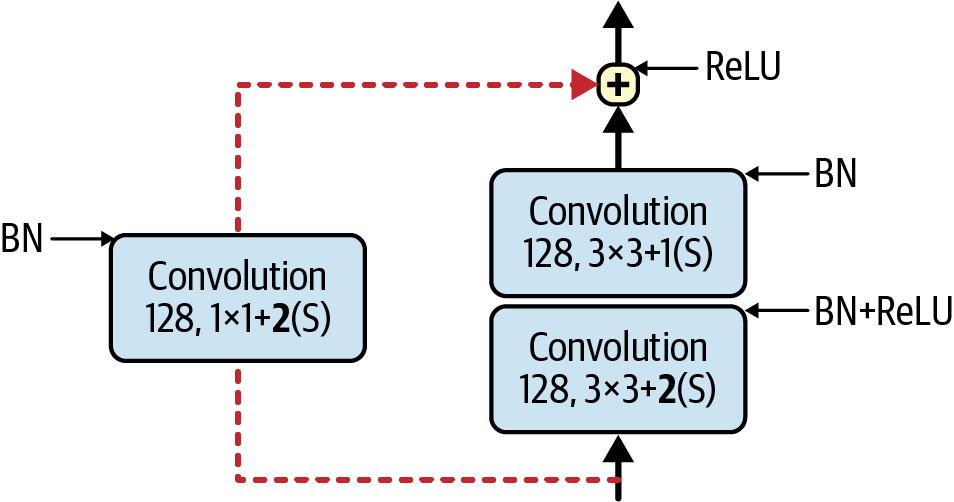